<a href="https://colab.research.google.com/github/Amisha1019/Image-Colorization-and-Generative-AI/blob/main/task_3_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# Add these imports near the top of your notebook
import torchvision.models as models
import torchvision.transforms.functional as TF
import matplotlib.patches as patches


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

No NVIDIA driver found. Using CPU


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [13]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

In [14]:
model = ColorizationNet().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [ ]:
EPOCHS = 5
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass

        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")

Epoch [1/5], Step [1/782], Loss: 0.0652
Epoch [1/5], Step [101/782], Loss: 0.0085
Epoch [1/5], Step [201/782], Loss: 0.0057
Epoch [1/5], Step [301/782], Loss: 0.0058
Epoch [1/5], Step [401/782], Loss: 0.0055
Epoch [1/5], Step [501/782], Loss: 0.0067
Epoch [1/5], Step [601/782], Loss: 0.0044
Epoch [1/5], Step [701/782], Loss: 0.0063
Epoch [2/5], Step [1/782], Loss: 0.0042


In [15]:
# --- HSV helpers (robust, for tensors in [0,1]) ---
def torch_rgb_to_hsv(rgb):
    # rgb: (B,3,H,W) in [0,1]
    r, g, b = rgb[:,0], rgb[:,1], rgb[:,2]   # each (B,H,W)
    max_val, _ = torch.max(rgb, dim=1)       # (B,H,W)
    min_val, _ = torch.min(rgb, dim=1)
    diff = (max_val - min_val).clamp(min=1e-6)

    # Hue
    h = torch.zeros_like(max_val)
    mask_r = (max_val == r)
    mask_g = (max_val == g)
    mask_b = (max_val == b)

    h[mask_r] = ((g - b)[mask_r] / diff[mask_r]) % 6.0
    h[mask_g] = ((b - r)[mask_g] / diff[mask_g]) + 2.0
    h[mask_b] = ((r - g)[mask_b] / diff[mask_b]) + 4.0
    h = h / 6.0
    h = h % 1.0
    h[diff == 0] = 0.0

    # Saturation
    s = diff / (max_val + 1e-6)
    s[max_val == 0] = 0.0

    v = max_val

    return torch.stack([h, s, v], dim=1)  # (B,3,H,W)

def torch_hsv_to_rgb(hsv):
    # hsv: (B,3,H,W) in [0,1]
    h, s, v = hsv[:,0], hsv[:,1], hsv[:,2]
    h6 = (h * 6.0) % 6.0
    i = torch.floor(h6).long()  # 0..5
    f = h6 - i.float()

    p = v * (1 - s)
    q = v * (1 - s * f)
    t = v * (1 - s * (1 - f))

    # Prepare output tensors
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    idx = (i == 0)
    r[idx] = v[idx]; g[idx] = t[idx]; b[idx] = p[idx]
    idx = (i == 1)
    r[idx] = q[idx]; g[idx] = v[idx]; b[idx] = p[idx]
    idx = (i == 2)
    r[idx] = p[idx]; g[idx] = v[idx]; b[idx] = t[idx]
    idx = (i == 3)
    r[idx] = p[idx]; g[idx] = q[idx]; b[idx] = v[idx]
    idx = (i == 4)
    r[idx] = t[idx]; g[idx] = p[idx]; b[idx] = v[idx]
    idx = (i == 5)
    r[idx] = v[idx]; g[idx] = p[idx]; b[idx] = q[idx]

    return torch.stack([r,g,b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    images: (B,3,H,W) in [0,1]
    returns (B,3,H,W) in [0,1]
    """
    # safety clamp
    images = images.clamp(0.0, 1.0)
    hsv = torch_rgb_to_hsv(images)
    hsv[:,1] = (hsv[:,1] * saturation_factor).clamp(0.0, 1.0)
    hsv[:,2] = (hsv[:,2] * value_factor).clamp(0.0, 1.0)
    rgb = torch_hsv_to_rgb(hsv)
    return rgb.clamp(0.0, 1.0)


In [16]:
# --- DeepLabV3 helper (pretrained) ---
@torch.no_grad()
def load_deeplab(device):
    # Use torchvision's pretrained segmentation model
    seg = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=False).to(device)
    seg.eval()
    return seg

def deeplab_predict_mask(seg_model, pil_img, device):
    """
    pil_img: PIL RGB image
    returns: label_mask (H,W) numpy int (label indices)
    """
    # Preprocess similar to torchvision examples
    trf = transforms.Compose([
        transforms.Resize(520),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    inp = trf(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = seg_model(inp)

In [1]:
import matplotlib.pyplot as plt

def visualize_all_three(original, grayscale, colorized):
    """
    Visualizes the original, grayscale, and colorized images.

    Args:
        original (torch.Tensor): The original RGB image tensor (B, 3, H, W).
        grayscale (torch.Tensor): The grayscale image tensor (B, H, W).
        colorized (torch.Tensor): The colorized RGB image tensor (B, 3, H, W).
    """
    batch_size = original.shape[0]
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display original image
        axes[0].imshow(original[i].permute(1, 2, 0))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # Display grayscale image
        axes[1].imshow(grayscale[i], cmap='gray')
        axes[1].set_title("Grayscale")
        axes[1].axis("off")

        # Display colorized image
        axes[2].imshow(colorized[i].permute(1, 2, 0))
        axes[2].set_title("Colorized")
        axes[2].axis("off")

        plt.show()

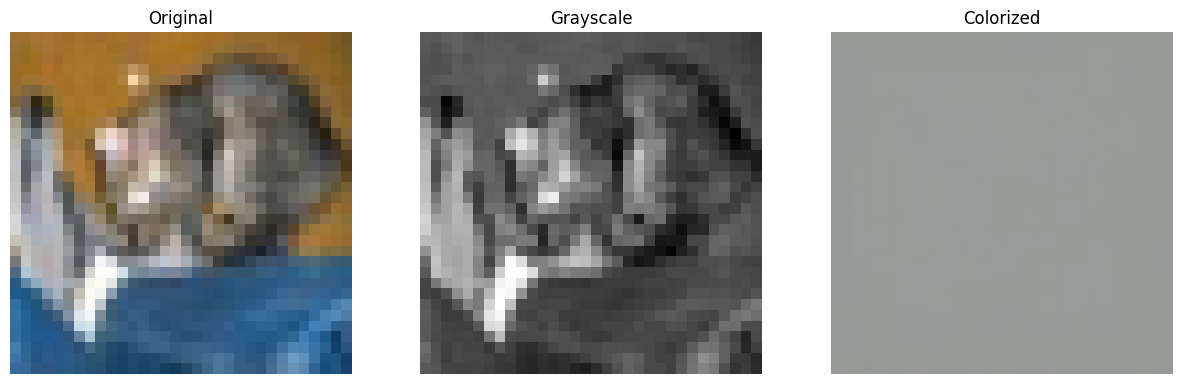

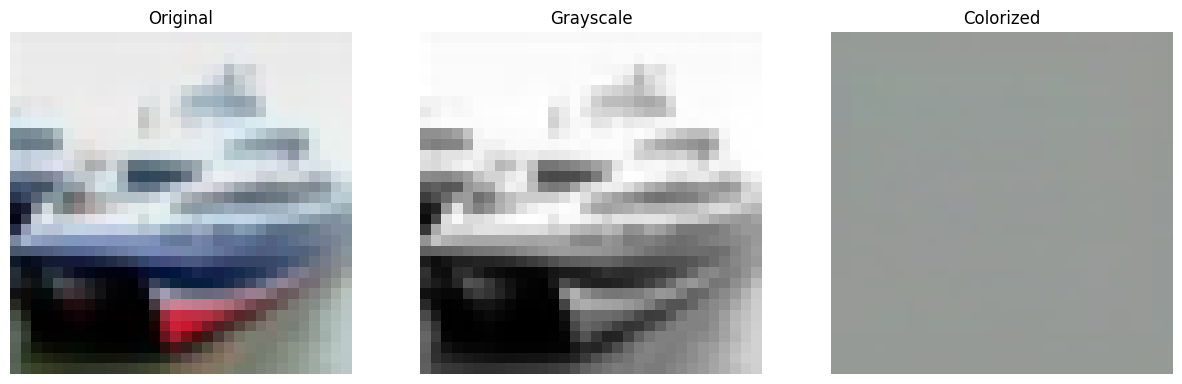

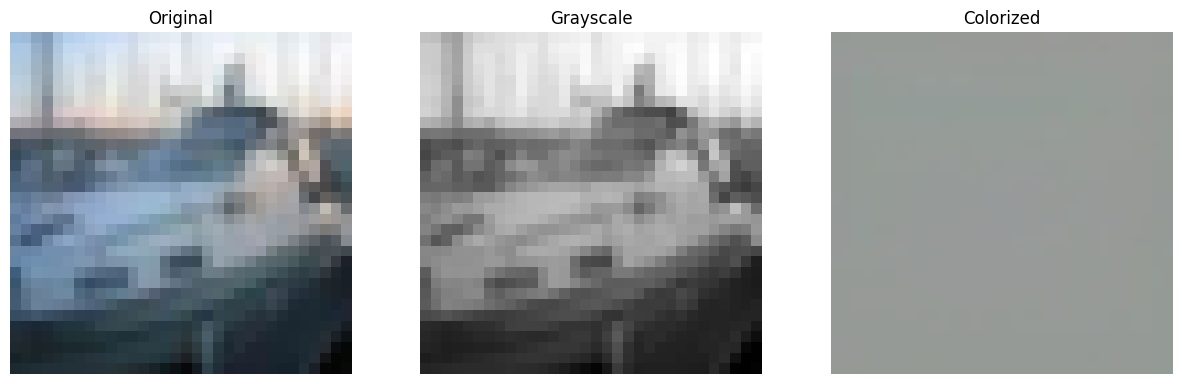

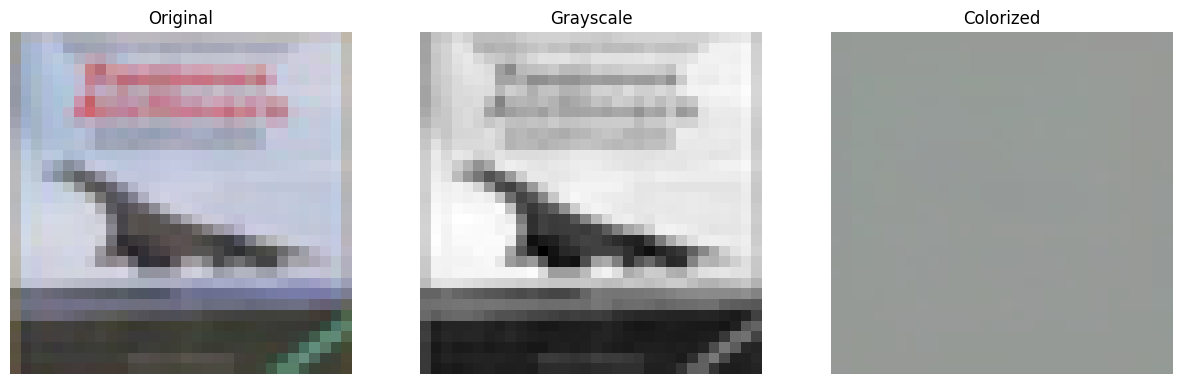

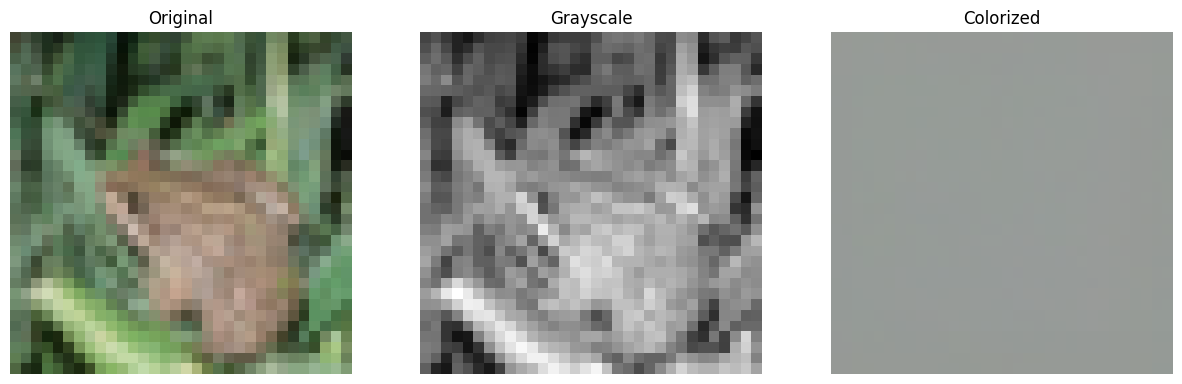

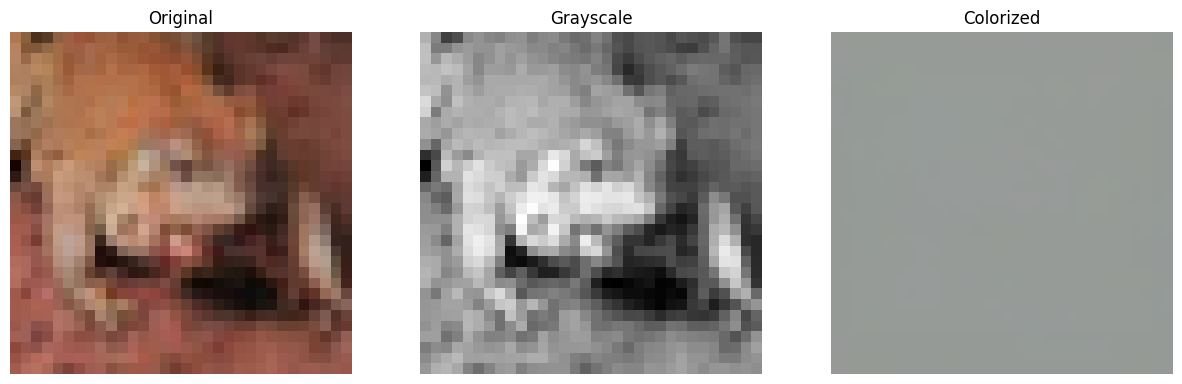

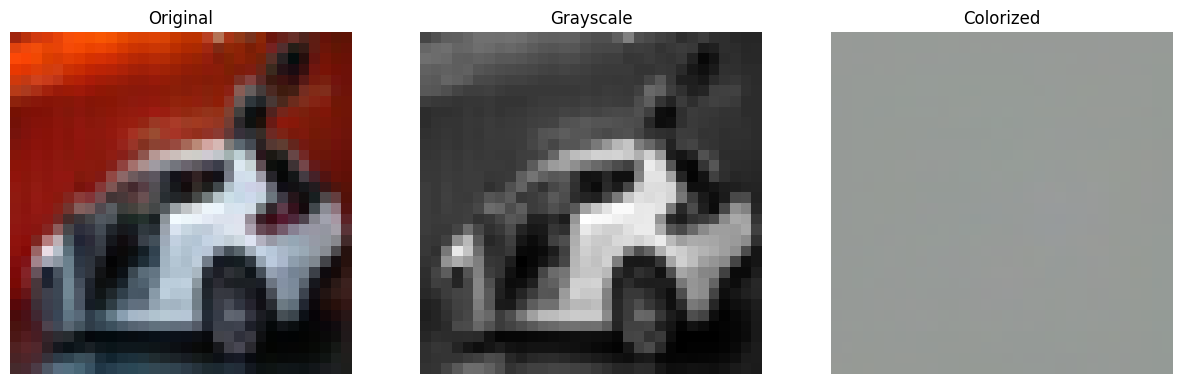

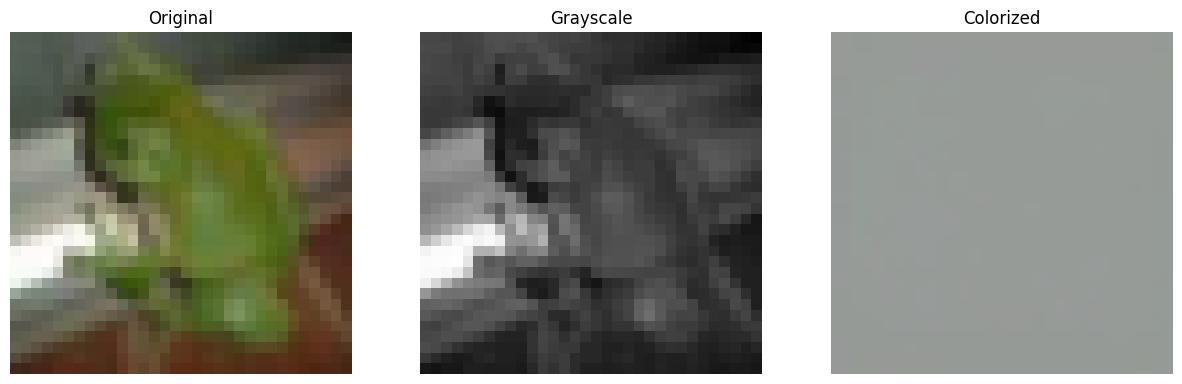

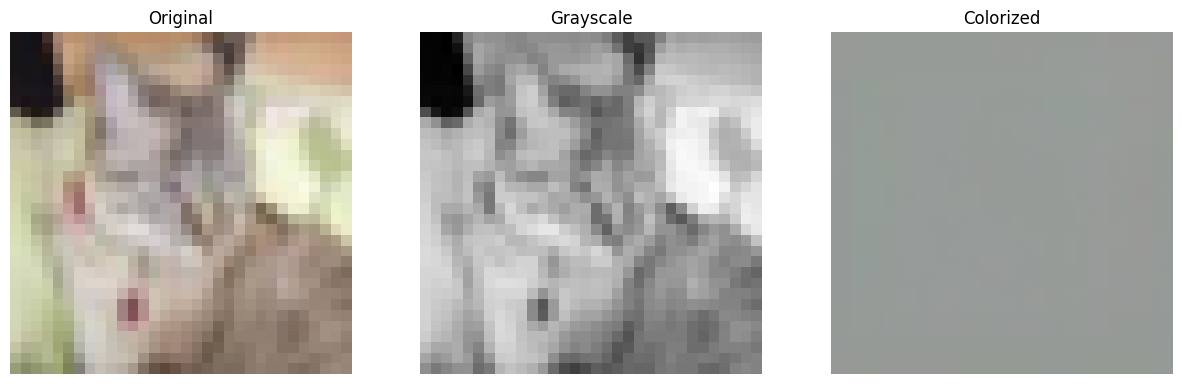

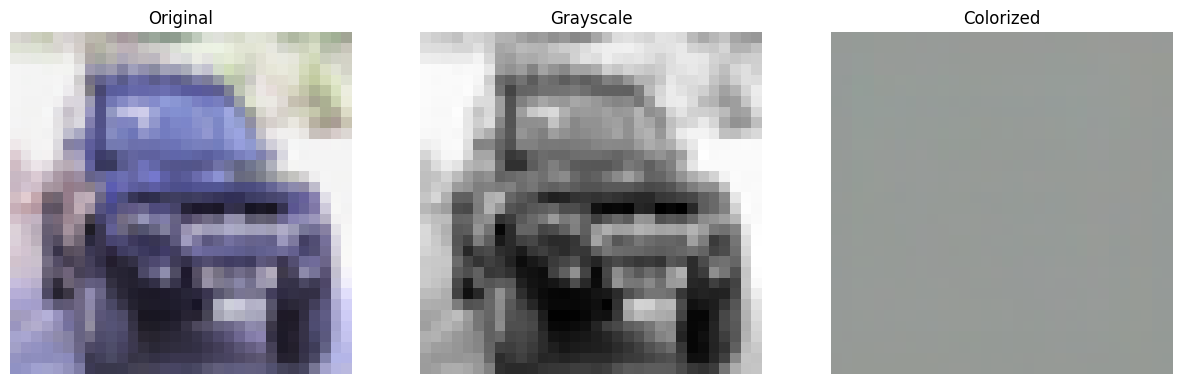

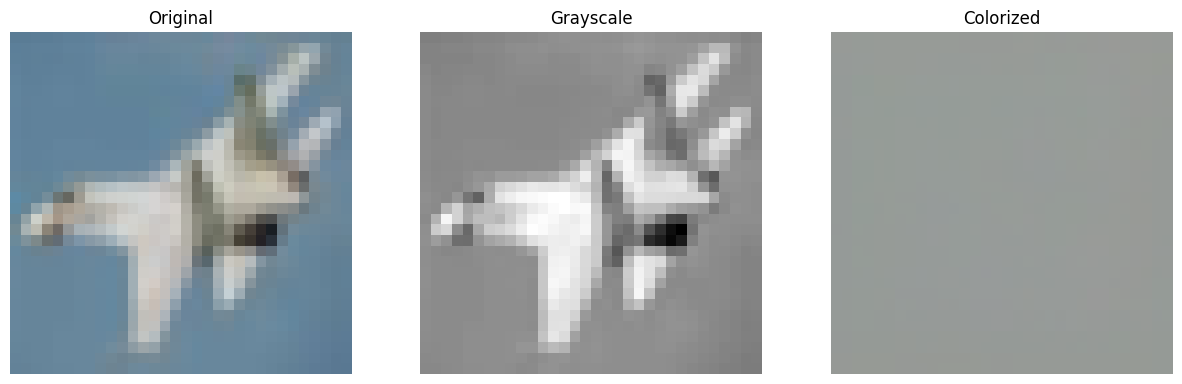

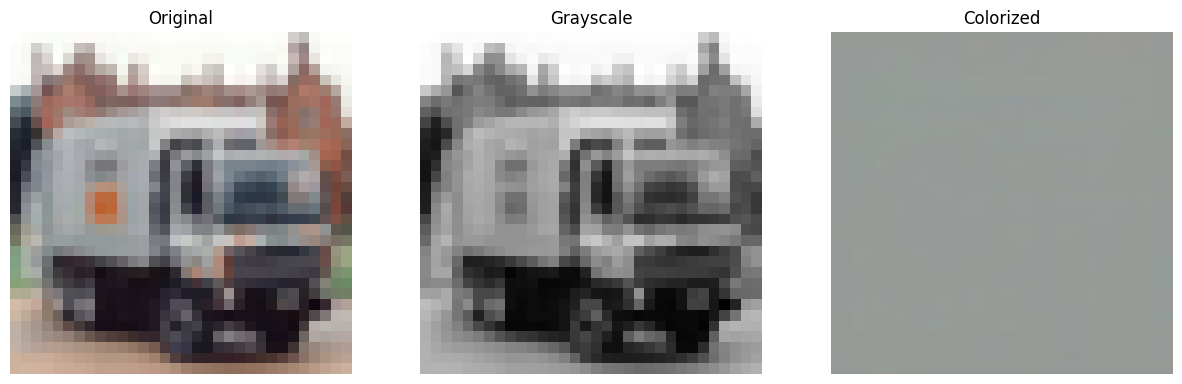

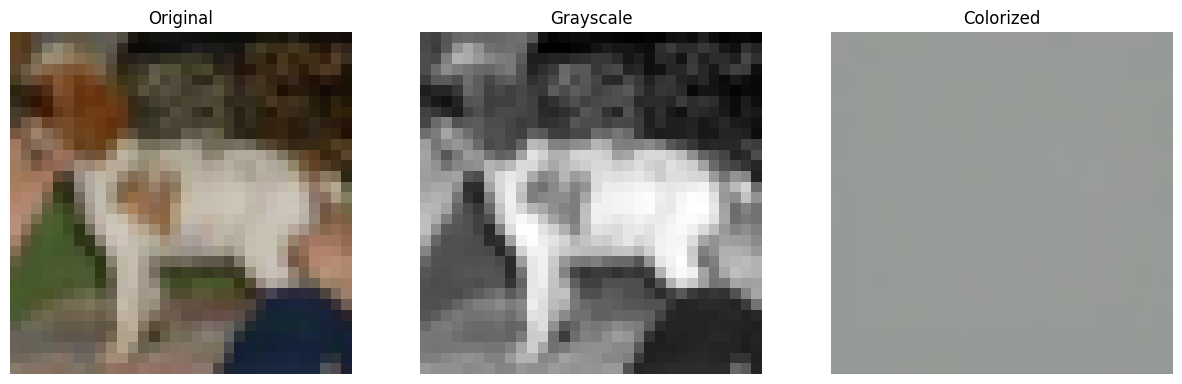

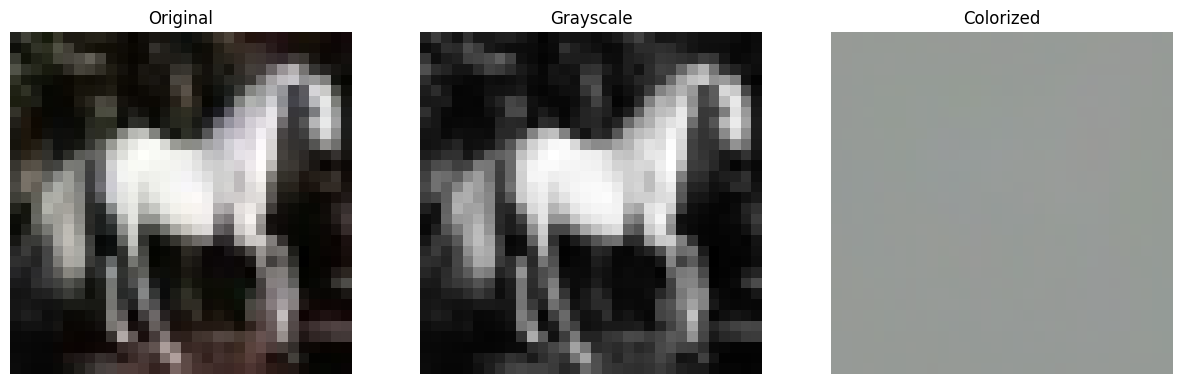

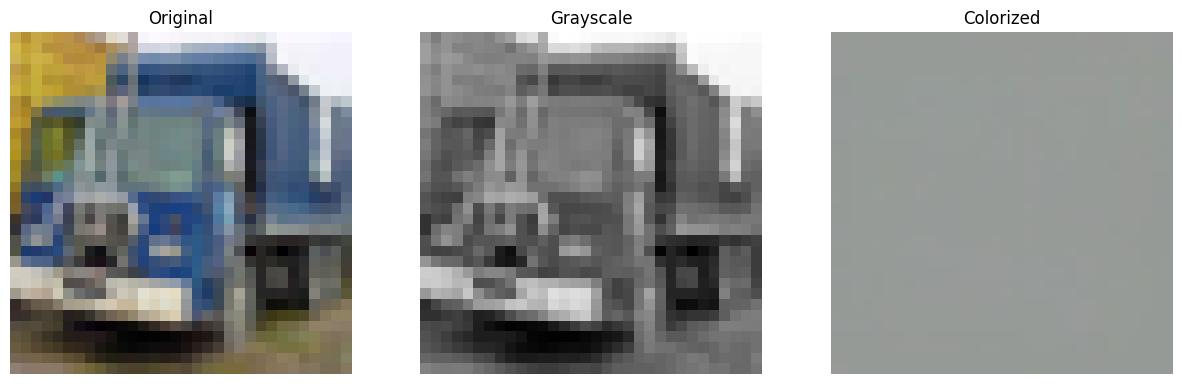

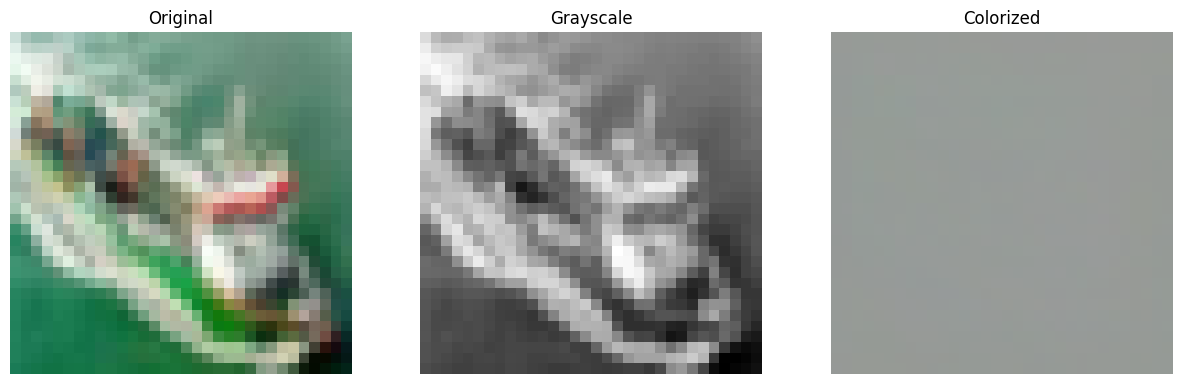

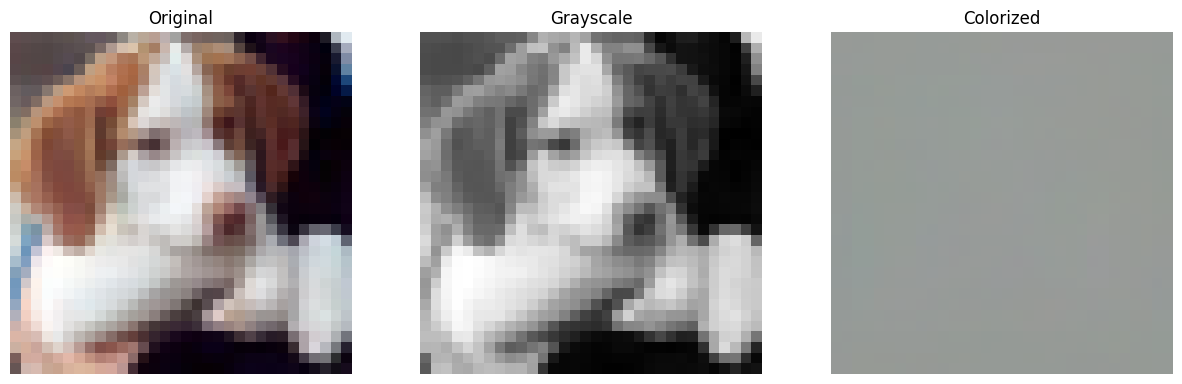

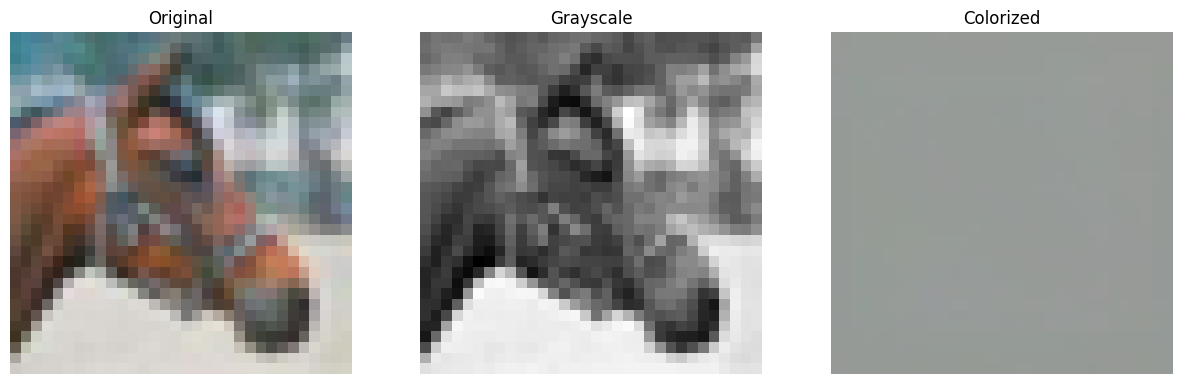

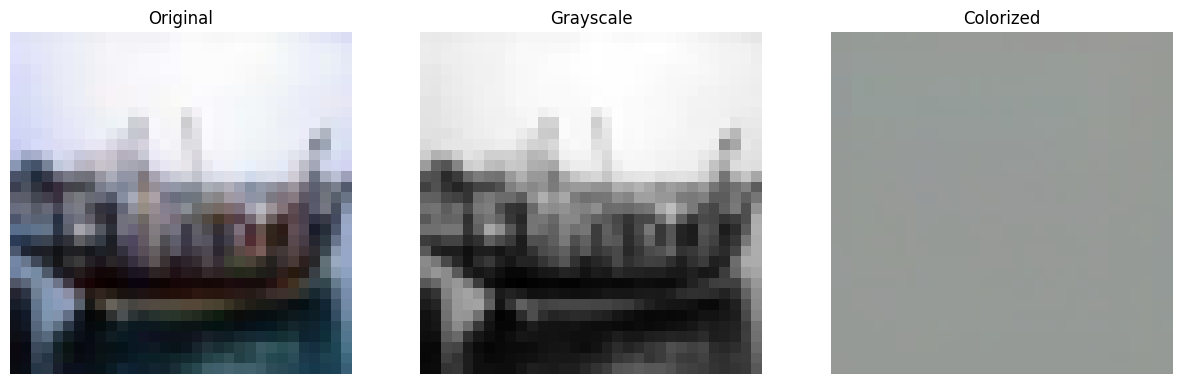

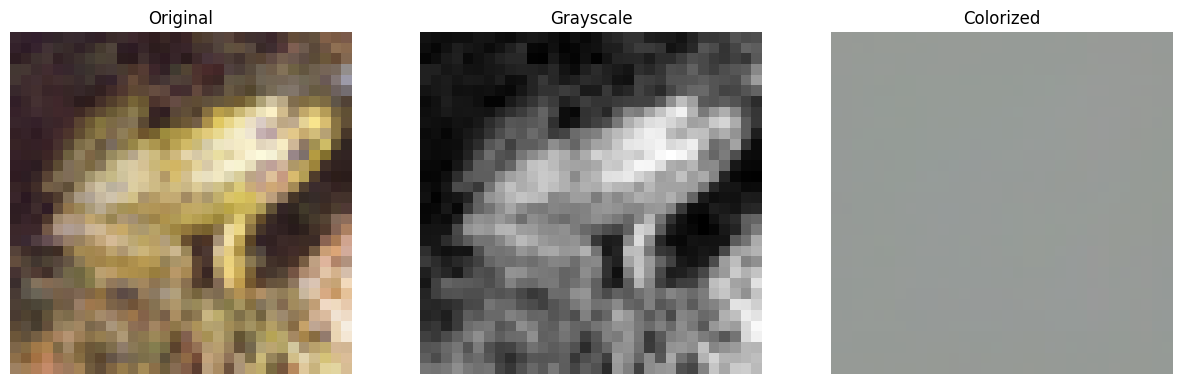

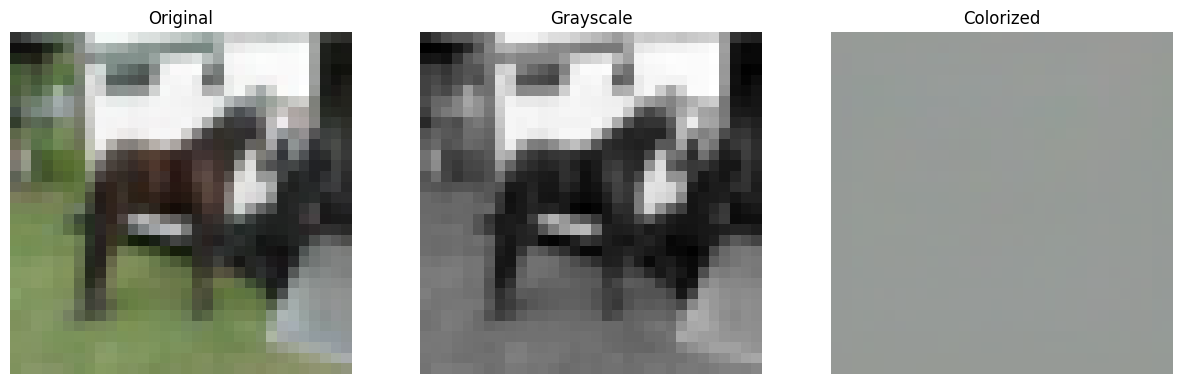

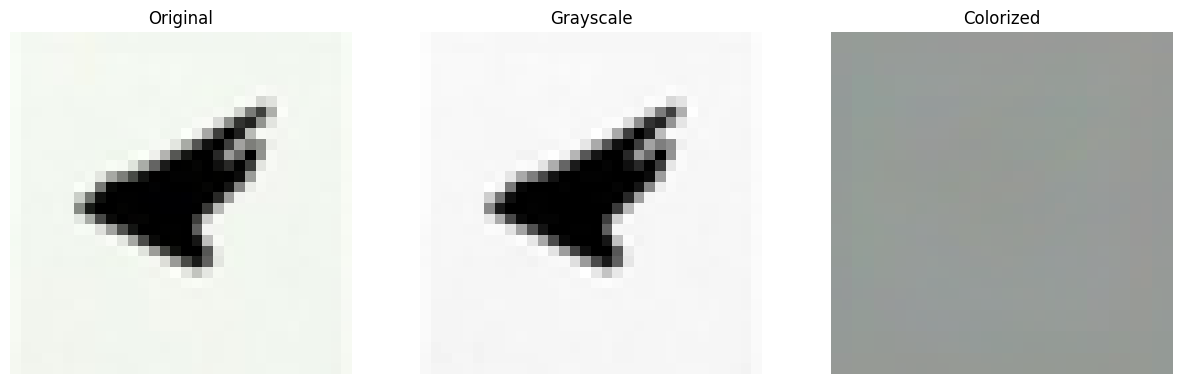

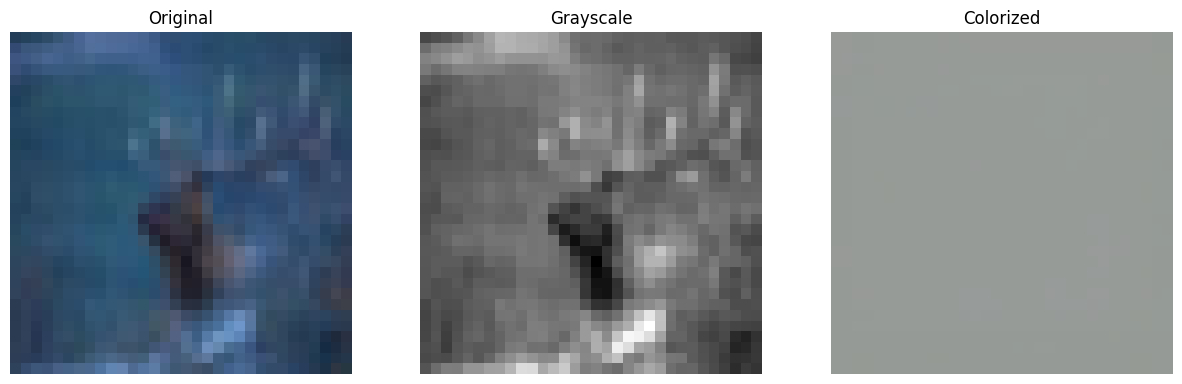

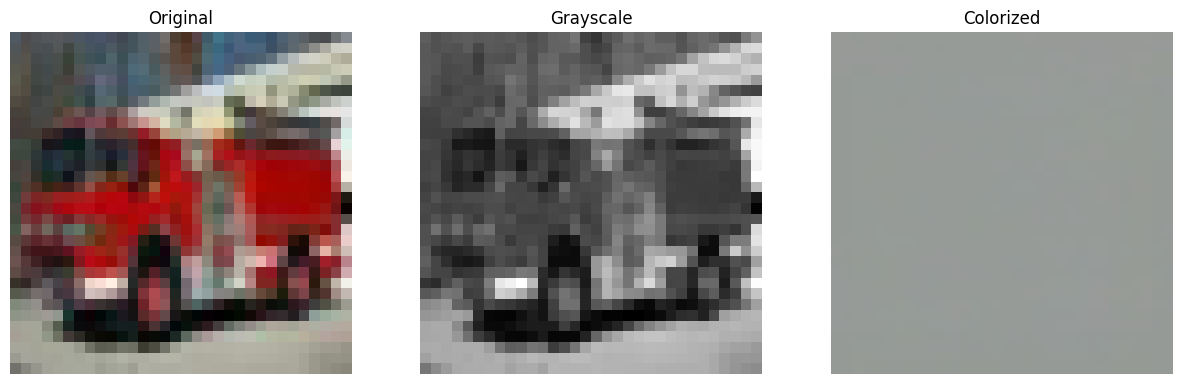

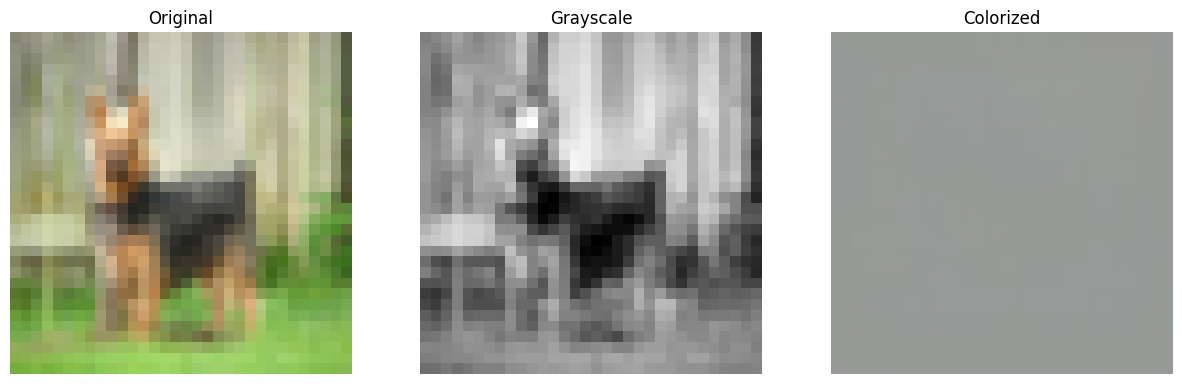

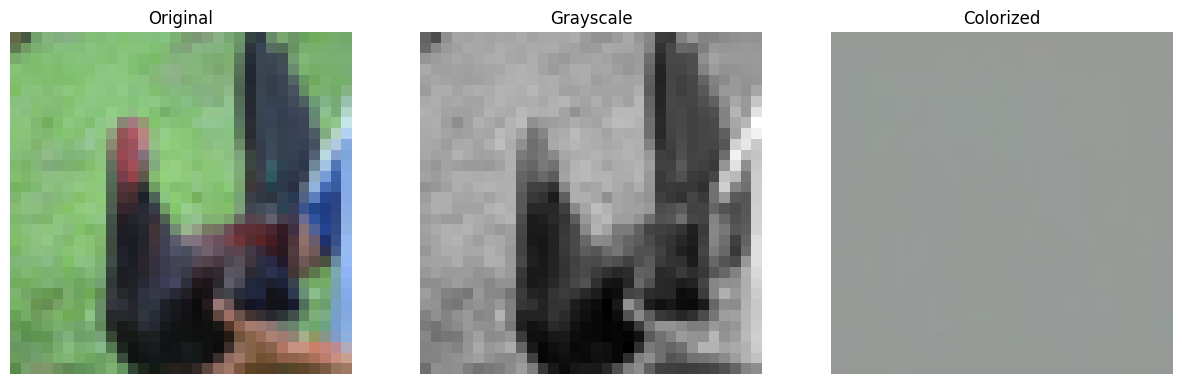

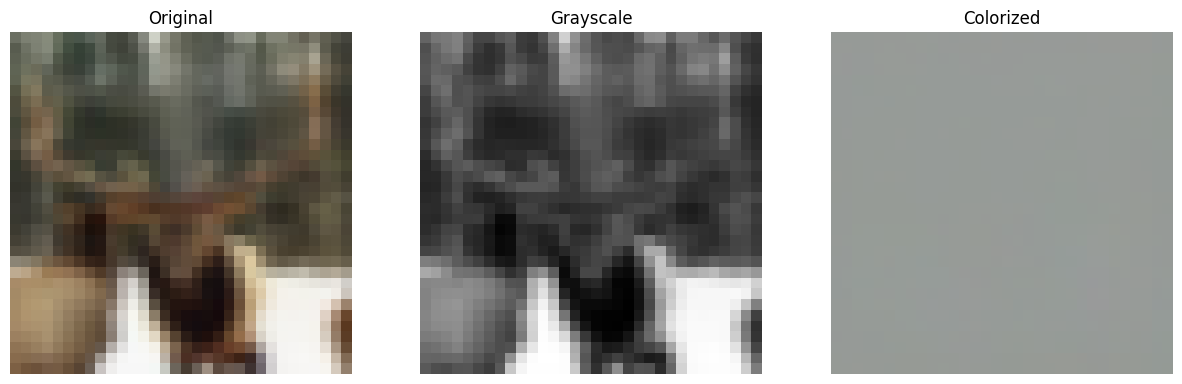

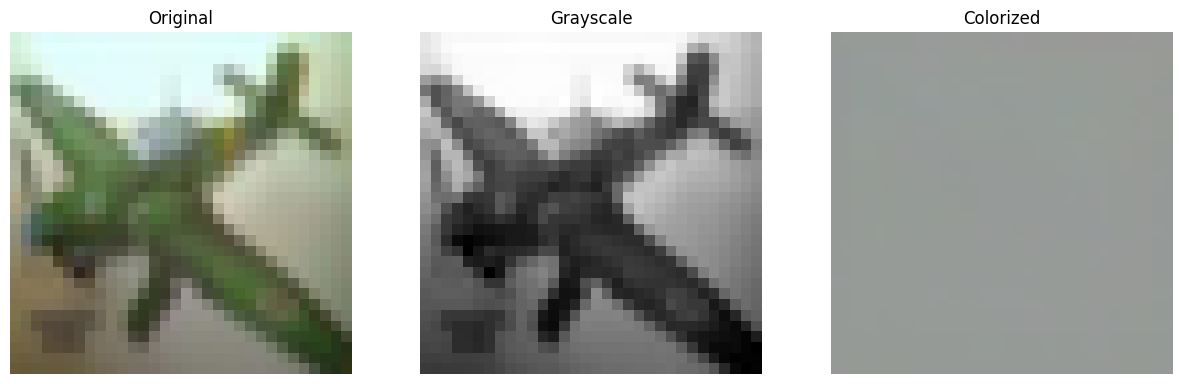

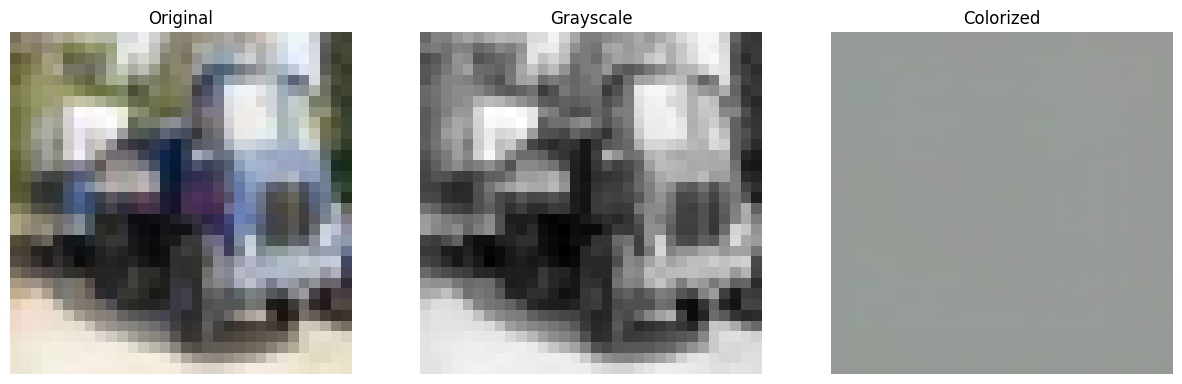

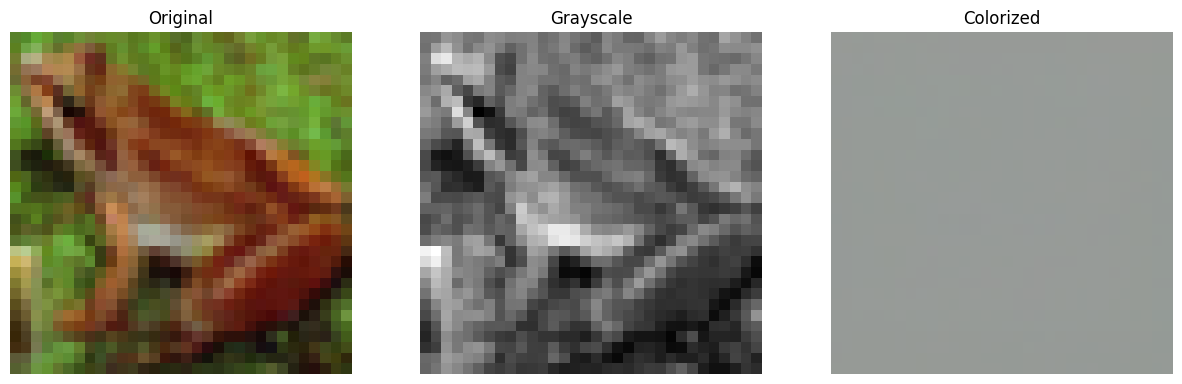

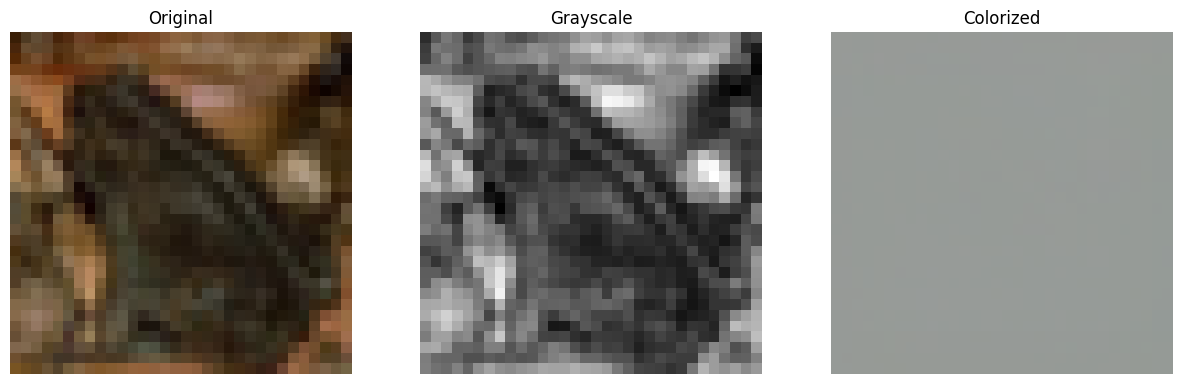

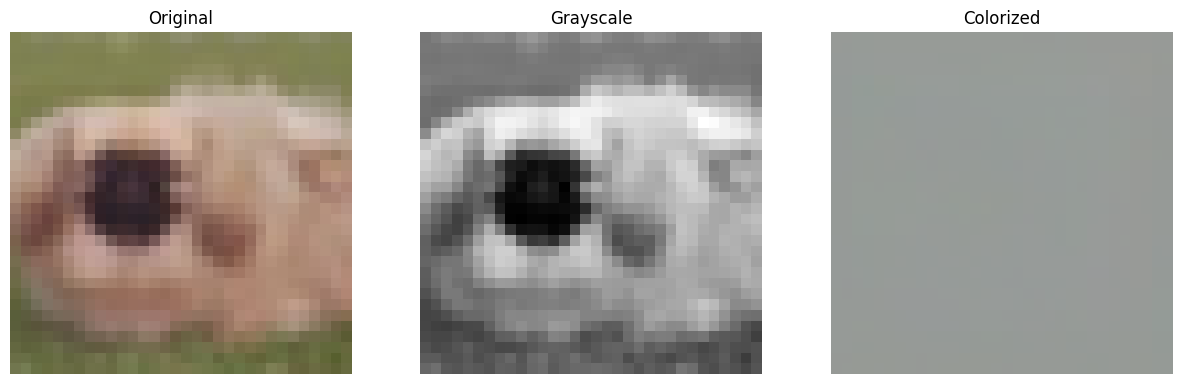

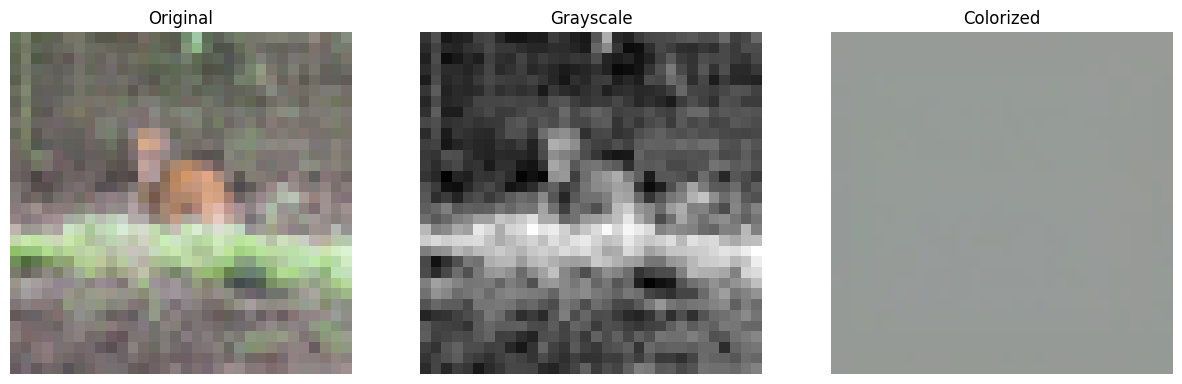

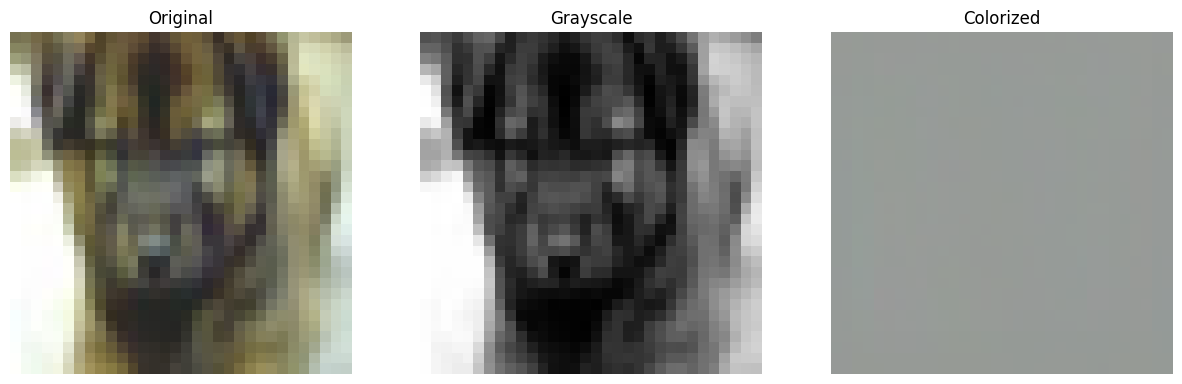

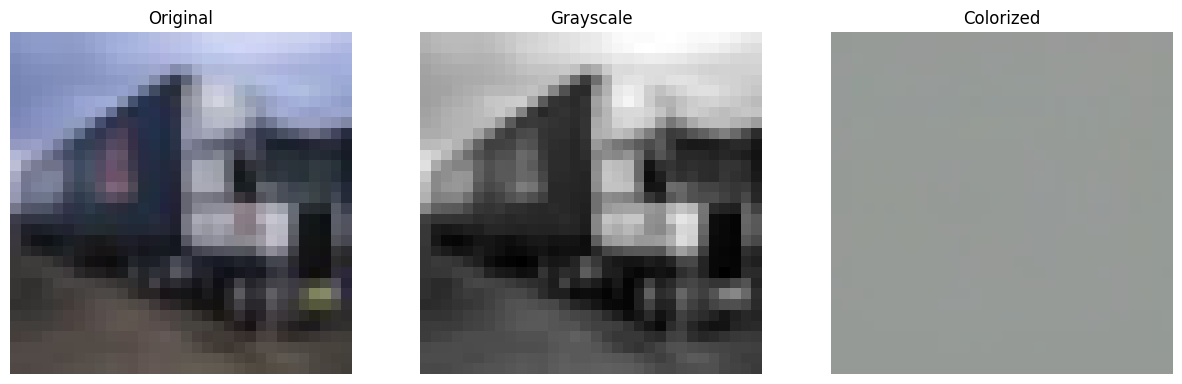

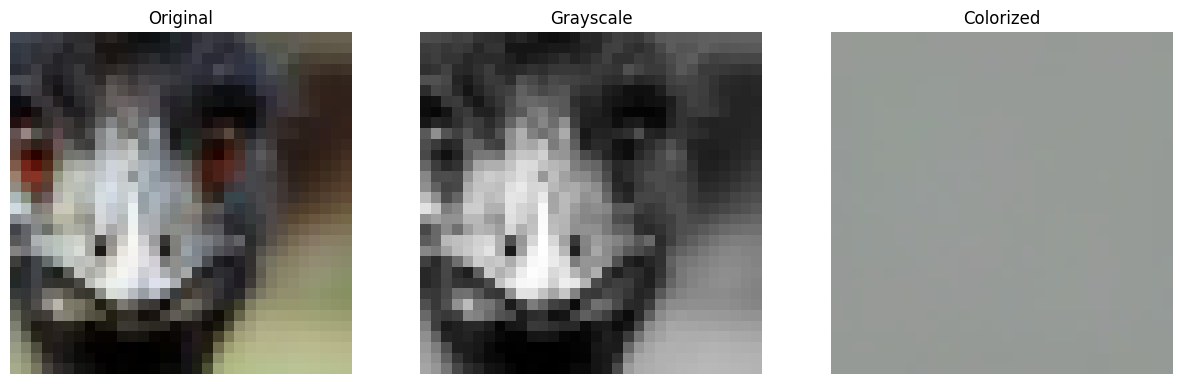

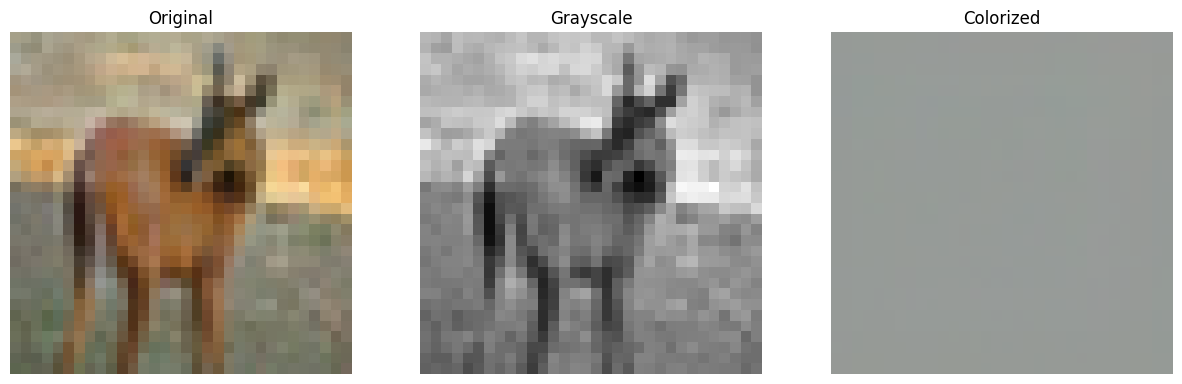

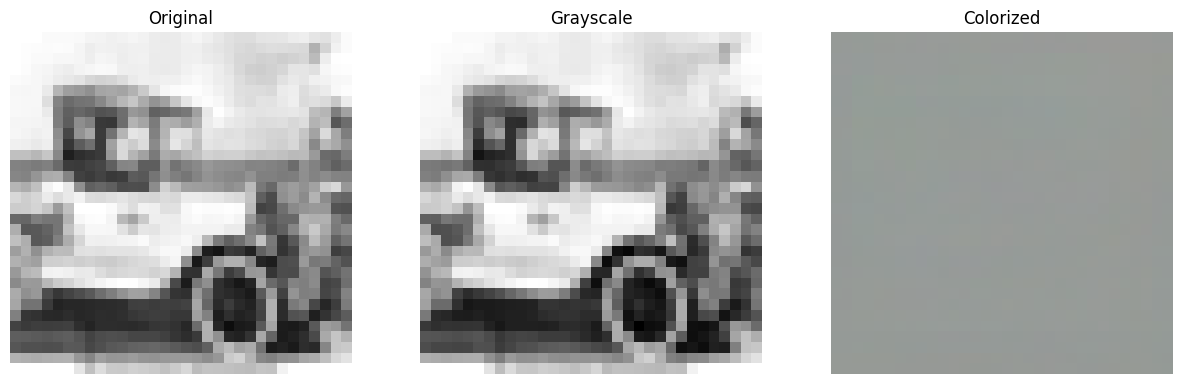

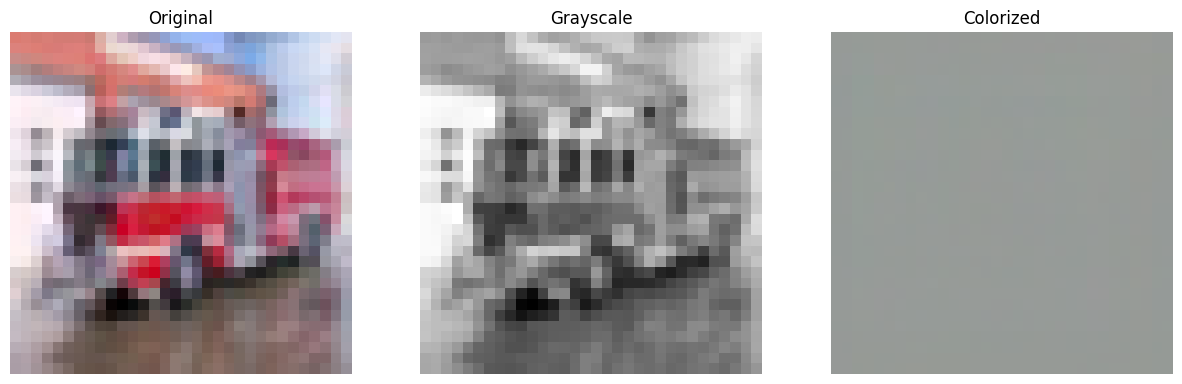

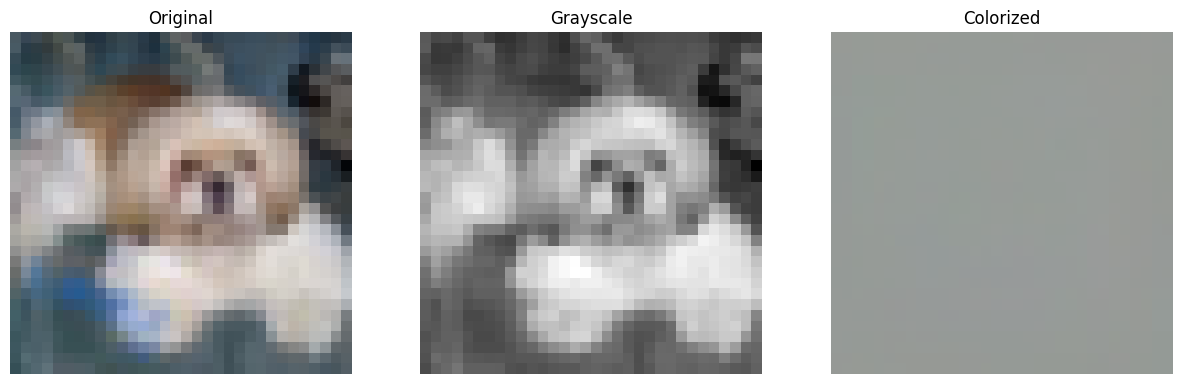

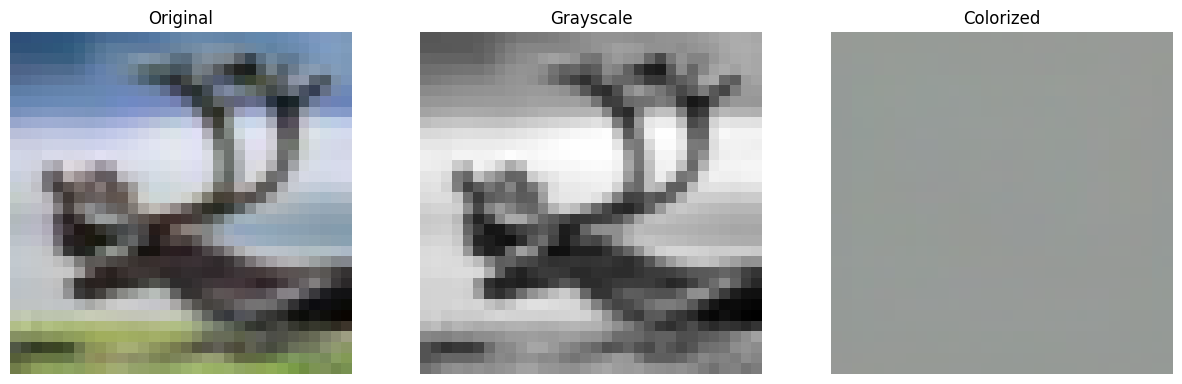

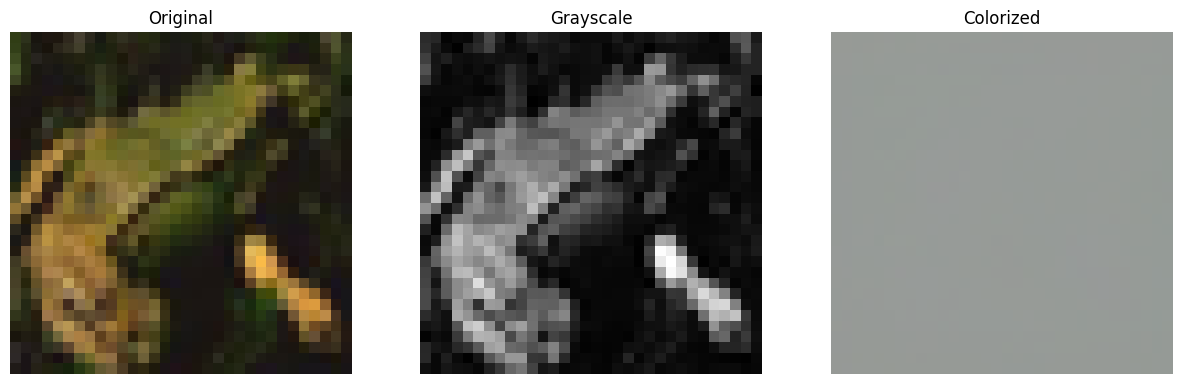

KeyboardInterrupt: 

In [17]:
with torch.no_grad():
    # Ensure the data loading cell (where test_loader is defined) is run before this cell.
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)


        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        # if i == 10:  # only do this for up to certain batch for demonstration purposes
        #     break

In [1]:
import matplotlib.pyplot as plt

def visualize_all_three(original, grayscale, colorized):
    """
    Visualizes the original, grayscale, and colorized images.

    Args:
        original (torch.Tensor): The original RGB image tensor (B, 3, H, W).
        grayscale (torch.Tensor): The grayscale image tensor (B, H, W).
        colorized (torch.Tensor): The colorized RGB image tensor (B, 3, H, W).
    """
    batch_size = original.shape[0]
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Display original image
        axes[0].imshow(original[i].permute(1, 2, 0))
        axes[0].set_title("Original")
        axes[0].axis("off")

        # Display grayscale image
        axes[1].imshow(grayscale[i], cmap='gray')
        axes[1].set_title("Grayscale")
        axes[1].axis("off")

        # Display colorized image
        axes[2].imshow(colorized[i].permute(1, 2, 0))
        axes[2].set_title("Colorized")
        axes[2].axis("off")

        plt.show()